In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from keras.layers.normalization import layer_normalization

2.6.0


In [2]:
IMAGE_SIZE=299
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=image_dataset_from_directory(
   "F:\project\COVID-19_Radiography_Dataset\data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 21165 files belonging to 4 classes.


In [4]:
classes=dataset.class_names
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [5]:
len(dataset)

662

(32, 299, 299, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 0,
       2, 1, 0, 2, 2, 2, 0, 1, 2, 1])>>


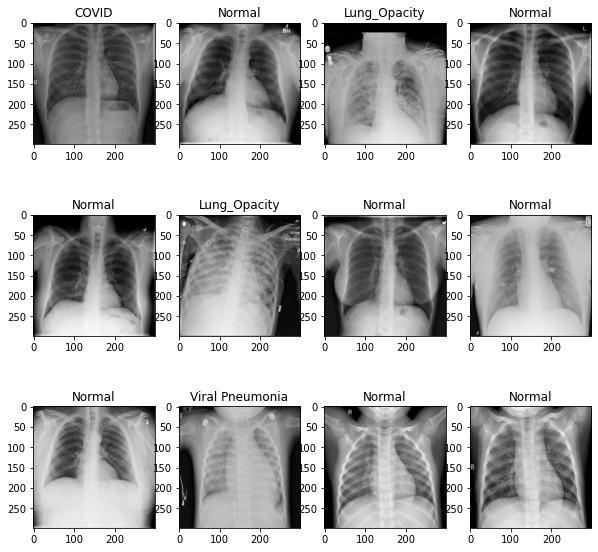

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])

In [7]:
train_ds=dataset.take(50)
len(train_ds)

50

In [8]:
test_ds=dataset.skip(50)
len(test_ds)

612

In [9]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [10]:
tst_ds=test_ds.skip(6)
len(tst_ds)

606

In [11]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shufflesize=10000):
    if shuffle:
        ds=ds.shuffle(shufflesize,seed=12)
    train_size=int(len(ds)*train_split)
    val_size=int(len(ds)*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset(dataset)
print(len(train_ds),len(val_ds),len(test_ds))

529 66 67


In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
start_neurons=16

In [15]:
ip_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
model=models.Sequential([
    resize_rescale,
#     layers.Conv2D(16,kernel_size=(3,3),activation="relu",input_shape=ip_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32,(3,3),activation="relu",input_shape=ip_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation="relu",input_shape=ip_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation="relu",input_shape=ip_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(256,(3,3),activation="relu",input_shape=ip_shape),
#     layers.MaxPooling2D((2,2)),
# #     layers.Conv2D(64,(3,3),activation="relu",input_shape=ip_shape),
# #     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64,activation="relu"),
#     layers.Dense(n_classes,activation="softmax")
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
])
model.build(input_shape=ip_shape)

SyntaxError: invalid syntax (<ipython-input-15-4387299317fc>, line 20)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 299, 299, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 297, 297, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 148, 148, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 146, 146, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 73, 73, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 71, 71, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 35, 35, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds

)

Epoch 1/10
50/50 [==============================] - 494s 8s/step - loss: 1.2821 - accuracy: 0.3460 - val_loss: 1.1081 - val_accuracy: 0.4583
Epoch 2/10
50/50 [==============================] - 259s 5s/step - loss: 0.7969 - accuracy: 0.6862 - val_loss: 0.5945 - val_accuracy: 0.7500
Epoch 3/10
50/50 [==============================] - 181s 4s/step - loss: 0.5393 - accuracy: 0.8043 - val_loss: 0.4410 - val_accuracy: 0.8333
Epoch 4/10
50/50 [==============================] - 287s 6s/step - loss: 0.4405 - accuracy: 0.8359 - val_loss: 0.4146 - val_accuracy: 0.8125
Epoch 5/10
50/50 [==============================] - 207s 4s/step - loss: 0.4151 - accuracy: 0.8428 - val_loss: 0.3779 - val_accuracy: 0.8438
Epoch 6/10
50/50 [==============================] - 206s 4s/step - loss: 0.3424 - accuracy: 0.8744 - val_loss: 0.2638 - val_accuracy: 0.9167
Epoch 7/10
50/50 [==============================] - 220s 4s/step - loss: 0.2979 - accuracy: 0.8826 - val_loss: 0.3171 - val_accuracy: 0.8802
Epoch 8/10
50

In [19]:
model.evaluate(test_ds)

7/7 [==============================] - 104s 1s/step - loss: 0.2284 - accuracy: 0.9330


[0.22841617465019226, 0.9330357313156128]

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss ')

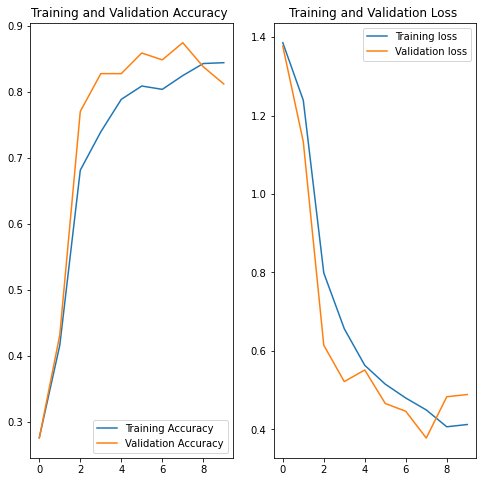

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss ')

first image to predict
actual_label=Normal
predicted label:COVID
first image to predict
actual_label=COVID
predicted label:Lung_Opacity
first image to predict
actual_label=COVID
predicted label:COVID
first image to predict
actual_label=Normal
predicted label:Normal
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=Normal
predicted label:Normal
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=COVID
predicted label:COVID
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia


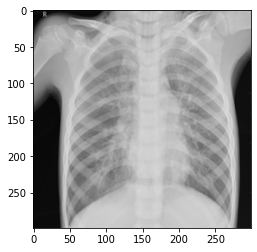

In [30]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    for i in range(10):
        first_image=images_batch[i].numpy().astype('uint8')
        first_label=label_batch[i].numpy()
        print("first image to predict")
        plt.imshow(first_image)
        print(f"actual_label={classes[first_label]}")

        batch_prediction=model.predict(images_batch)
        print(f"predicted label:{classes[np.argmax(batch_prediction[i])]}")
        
        